## Chapter 5: Types of Conformal Predictors

- We've already discussed both TCP and ICP in Chapter 3, so there is a lot of overlap. 

- In this notebook we'll implement TCP from scratch for classification

### TCP in Practise (Classification)

- https://github.com/PacktPublishing/Practical-Guide-to-Applied-Conformal-Prediction/blob/main/Chapter_05_TCP.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from scipy.stats import rankdata

import openml

from sklearn.metrics import log_loss, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from  sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import label_binarize

import plotly.express as px

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
# from catboost import CatBoostClassifier

from nonconformist.cp import TcpClassifier
from nonconformist.nc import NcFactory
from nonconformist.nc import InverseProbabilityErrFunc, MarginErrFunc


import warnings
warnings.filterwarnings('ignore')

#### Get dataset

In [2]:
datasets_df = openml.datasets.list_datasets(output_format="dataframe")
datasets_df.loc[31]

did                                         31
name                                  credit-g
version                                      1
uploader                                     1
status                                  active
format                                    ARFF
MajorityClassSize                        700.0
MaxNominalAttDistinctValues               10.0
MinorityClassSize                        300.0
NumberOfClasses                            2.0
NumberOfFeatures                          21.0
NumberOfInstances                       1000.0
NumberOfInstancesWithMissingValues         0.0
NumberOfMissingValues                      0.0
NumberOfNumericFeatures                    7.0
NumberOfSymbolicFeatures                  14.0
Name: 31, dtype: object

In [3]:
# German credit dataset https://www.openml.org/d/31
dataset = openml.datasets.get_dataset(31)

# Print a summary
print(
    f"This is dataset '{dataset.name}', the target feature is "
    f"'{dataset.default_target_attribute}'"
)
print(f"URL: {dataset.url}")
print(dataset.description)

This is dataset 'credit-g', the target feature is 'class'
URL: https://api.openml.org/data/v1/download/31/credit-g.arff
**Author**: Dr. Hans Hofmann  
**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)) - 1994    
**Please cite**: [UCI](https://archive.ics.uci.edu/ml/citation_policy.html)

**German Credit dataset**  
This dataset classifies people described by a set of attributes as good or bad credit risks.

This dataset comes with a cost matrix: 
``` 
Good  Bad (predicted)  
Good   0    1   (actual)  
Bad    5    0  
```

It is worse to class a customer as good when they are bad (5), than it is to class a customer as bad when they are good (1).  

### Attribute description  

1. Status of existing checking account, in Deutsche Mark.  
2. Duration in months  
3. Credit history (credits taken, paid back duly, delays, critical accounts)  
4. Purpose of the credit (car, television,...)  
5. Credit amount  
6. Status of savings account/bonds, in Deutsch

In [4]:
# openml API
X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="array", target=dataset.default_target_attribute
)
df = pd.DataFrame(X, columns=attribute_names)
df["class"] = y

In [5]:
df['class'].value_counts()

class
0    700
1    300
Name: count, dtype: int64

#### Prep Dataset

In [23]:
X = df.drop('class', axis = 1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Train model

In [24]:
# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [25]:
# make point predictions and obtain class scores
y_pred_test = model.predict(X_test)
y_pred_score_test = model.predict_proba(X_test)

print('Classification accuracy: {}'.format(accuracy_score(y_test, y_pred_test)))
print('ROC AUC: {}'.format(roc_auc_score(y_test, y_pred_score_test[:,1]))) 
# predict classification scores on the training set
y_pred_score_train = model.predict_proba(X_train)

Classification accuracy: 0.775
ROC AUC: 0.7927380952380952


#### Define nonconformity score measure

- We use inverse probability nonconformity measure (also known as hinge loss). 

- The function below calculates the probability of not predicting the correct class by simply looking up probability score predicted by the underlying model for the correct class and subtracting it from 1. 

- For each correct output in y, inverse probablity nonconformity (hinge loss) score  is defined as $1 - \hat{P}(y_i | x)$ 

- This measure is also known as a hinge loss and is based simply on the probability estimate provided by the underlying point classification model for the correct class label $y_i$

In [26]:
def InverseProbabilityNC(predicted_score, y):
    '''
    predicted_score:
        - n x k array, where n is the number of obs in the training set plus the new observation, and k is the number of possible classes
    y:
        - (n+1,) array, containing outcomes of the n observations in the training set plus the assumed outcome for the 1 new observation 
    '''
    prob = np.zeros(y.size, dtype=np.float32)
  
    ## Looping across all n+1 observed/assumed outcomes
    for i, y_ in enumerate(y):
        
        ## Error handling: If outcome label falls outside of the prediction scope (i.e. outside the k possible outcomes defined in the prediction), store probability as 0
        if y_ >= predicted_score.shape[1]:  
            prob[i] = 0

        ## Otherwise, record the predicted probability of that particular class
        else:
            prob[i] = predicted_score[i, int(y_)]

    ## Hinge loss is computed as 1 - predicted probability of the correct class
    return 1 - prob

In [27]:
## Append 1 new observation to training data
X_train_plus_test = pd.concat([X_train,pd.DataFrame(X_test.iloc[0]).T])
print(X_train.shape, X_test.shape, X_train_plus_test.shape)

(800, 20) (200, 20) (801, 20)


In [28]:
# In TCP, we have to refit the model assuming the 1 new observation takes on all of the possible labels (in this case, 0 and 1)
y_train_plus_test_0 = np.append(y_train, 0)
y_train_plus_test_1 = np.append(y_train, 1)
print(y_train_plus_test_0.shape, y_train_plus_test_0.shape)

(801,) (801,)


In [29]:
## Refit model assuming new observation is label 0
model.fit(X_train_plus_test, y_train_plus_test_0)
y_pred_score_train_plus_test_0 = model.predict_proba(X_train_plus_test)
print(y_pred_score_train_plus_test_0.shape)

(801, 2)


In [30]:
## Refit model assuming new observation is label 1
model.fit(X_train_plus_test, y_train_plus_test_1)
y_pred_score_train_plus_test_1 = model.predict_proba(X_train_plus_test)
print(y_pred_score_train_plus_test_1.shape)

(801, 2)


In [31]:
# Compute the nonconformity scores for all training data PLUS the new observation, across all possible labels for the new observation
non_conformity_scores_train_plus_test_0 = InverseProbabilityNC(y_pred_score_train_plus_test_0, y_train_plus_test_0)
non_conformity_scores_train_plus_test_1 = InverseProbabilityNC(y_pred_score_train_plus_test_1, y_train_plus_test_1)
print(non_conformity_scores_train_plus_test_0.shape, non_conformity_scores_train_plus_test_1.shape)

(801,) (801,)


In [32]:
# extract nonconformity scores for the training set
non_conformity_scores_y_train_class_0 = non_conformity_scores_train_plus_test_0[:-1]
non_conformity_scores_y_train_class_1 = non_conformity_scores_train_plus_test_1[:-1]

# extract nonconformity scores for the test observation
non_conformity_scores_y_test_class_0 = non_conformity_scores_train_plus_test_0[-1]
non_conformity_scores_y_test_class_1 = non_conformity_scores_train_plus_test_1[-1]

#### Compute p-values of training set and "new" observation

In [33]:
from typing import Iterable

def compute_p_value(non_conformity_scores_train, non_conformity_scores_test):
    '''
    non_conformity_scores_train:
        - The nonconformity scores computed from the n observations in the training set
    
    non_conformity_scores_test:
        - The nonconformity score computed from the 1 observation we want to test
    '''
    p_values = []
    if not isinstance(non_conformity_scores_test, list):
        non_conformity_scores_test = [non_conformity_scores_test]

    for i, test_point_conformity_score in enumerate(non_conformity_scores_test):
        p_value = (np.sum(non_conformity_scores_train >= test_point_conformity_score) + 1) / (len(non_conformity_scores_train)+1)
        p_values.append(p_value)  
    return np.array(p_values)

# Alternative way to compute p-values using ranks of nonconformity scores
def alternative_compute_p_value(non_conformity_scores_train, non_conformity_scores_test):
    '''
    non_conformity_scores_train:
        - The nonconformity scores computed from the n observations in the training set
    non_conformity_scores_test:
        - The nonconformity score computed from the 1 observation we want to test
    '''
    p_values = []
    if not isinstance(non_conformity_scores_test, list):
        non_conformity_scores_test = [non_conformity_scores_test]

    # Step 1 - sort non_conformity_scores_train in descending order
    A_sorted = np.sort(non_conformity_scores_train)[::-1]
    
    # Step 2 - calculate the rank R of the test instance's nonconformity score, the rank is position in the sorted sequence where nonconformity score alpha for the test object will be inserted
    for i,_ in enumerate(non_conformity_scores_test):
        A_sorted_append = np.append(A_sorted, non_conformity_scores_test[i])
        R = rankdata(A_sorted_append)[-1]
        
        # Step 3 - p-value is computed using rank R as: p_value = R / (n+1), where n is the length of the training set
        p_value = R / (len(non_conformity_scores_train)+1)
        p_values.append(p_value)  
    
    return np.array(p_values)

In [35]:
# compute p-value of the test point twice, each time assigning potential label 0 and 1
p_value_class_0 = compute_p_value(non_conformity_scores_y_train_class_0, non_conformity_scores_y_test_class_0)
p_value_class_1 = compute_p_value(non_conformity_scores_y_train_class_1, non_conformity_scores_y_test_class_1)
print(f'p-value for class 0: {p_value_class_0}, p-value for class 1: {p_value_class_1}')

p-value for class 0: [0.58926342], p-value for class 1: [0.06117353]


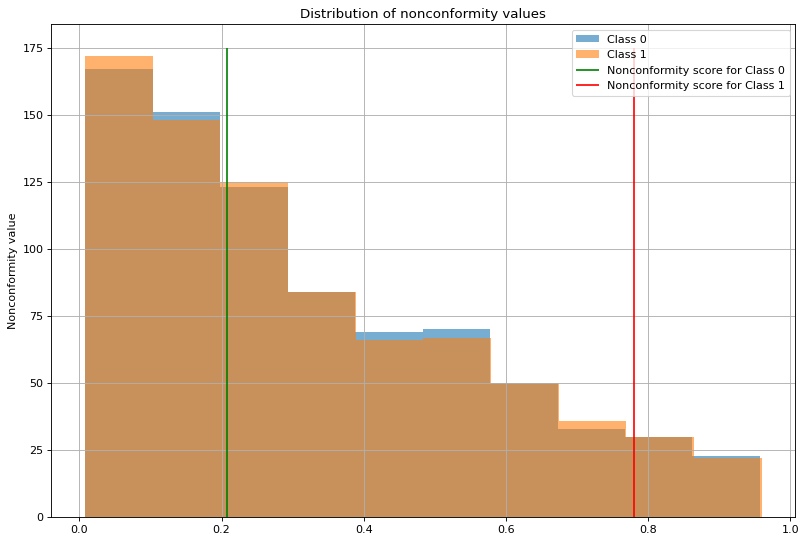

In [18]:
# plot distribution of nonconformity score for both situations
plt.figure(figsize=(12, 8), dpi=80)
plt.hist(np.sort(non_conformity_scores_y_train_class_0), label='Class 0', alpha=0.6)
plt.hist(np.sort(non_conformity_scores_y_train_class_1), label='Class 1', alpha=0.6)

# single line
plt.vlines(x = non_conformity_scores_y_test_class_0, ymin = 0, ymax = 175, colors = 'green',
           label = 'Nonconformity score for Class 0')

plt.vlines(x = non_conformity_scores_y_test_class_1, ymin = 0, ymax = 175, colors = 'red',
           label = 'Nonconformity score for Class 1')

plt.grid(True)
plt.ylabel('Nonconformity value')
plt.title('Distribution of nonconformity values')
 
plt.legend( loc='upper right')
plt.show()

#### Compute Prediction Sets

- Combining all the steps above into 1 function

- For each test observation, function returns the prediction sets and two sets of p-values for each potential label 0 and 1 

In [36]:
def prediction_sets(X_train, y_train, X_test, y_test, model = LogisticRegression(), significance_level = 0.05):
    prediction_sets = []
    p_values_class_0 = []
    p_values_class_1 = []

    for i,y in enumerate(y_test):
        # add test point to the training set 
        X_train_plus_test = pd.concat([X_train,pd.DataFrame(X_test.iloc[i]).T])
        y_train_plus_test_0 = np.append(y_train, 0)
        y_train_plus_test_1 = np.append(y_train, 1)

        # train the underlying classifier twice - two models for each potential value of the lable - 0 and 1
        model.fit(X_train_plus_test, y_train_plus_test_0)
        y_pred_score_train_plus_test_0 = model.predict_proba(X_train_plus_test)
        model.fit(X_train_plus_test, y_train_plus_test_1)
        y_pred_score_train_plus_test_1 = model.predict_proba(X_train_plus_test)

        #compute nonconformity scores
        non_conformity_scores_train_plus_test_0 = InverseProbabilityNC(y_pred_score_train_plus_test_0, y_train_plus_test_0)
        non_conformity_scores_train_plus_test_1 = InverseProbabilityNC(y_pred_score_train_plus_test_1, y_train_plus_test_1)

        non_conformity_scores_y_train_class_0 = non_conformity_scores_train_plus_test_0[:-1]
        non_conformity_scores_y_train_class_1 = non_conformity_scores_train_plus_test_1[:-1]

        non_conformity_scores_y_test_class_0 = non_conformity_scores_train_plus_test_0[-1]
        non_conformity_scores_y_test_class_1 = non_conformity_scores_train_plus_test_1[-1]

        p_value_class_0 = compute_p_value(non_conformity_scores_y_train_class_0, non_conformity_scores_y_test_class_0)
        p_value_class_1 = compute_p_value(non_conformity_scores_y_train_class_1, non_conformity_scores_y_test_class_1)

        p_values_class_0.append( p_value_class_0)
        p_values_class_1.append( p_value_class_1)

        if (p_value_class_0 > significance_level) and (p_value_class_1 > significance_level):
            prediction_sets.append([True,True])
        elif (p_value_class_0 > significance_level) and (p_value_class_1 <= significance_level):
            prediction_sets.append([True,False])
        elif (p_value_class_0 <= significance_level) and (p_value_class_1 >significance_level):
            prediction_sets.append([False,True])
        else:  
            prediction_sets.append([False,False])

    return prediction_sets, p_values_class_0, p_values_class_1

In [37]:
predictions_test_sets, p_values_test_set_class_0, p_values_test_set_class_1 = prediction_sets(X_train, y_train, X_test, y_test, model = LogisticRegression(), significance_level = 0.05)

#### Compare with open source implementation

In [38]:
# Create a default nonconformity function, this is the inverse probability (hinge loss) nonconformity measure we used above
nc = NcFactory.create_nc(model,err_func=InverseProbabilityErrFunc())

# Create a transductive conformal classifier
tcp = TcpClassifier(nc)
tcp.fit(X_train, y_train)
prediction = tcp.predict(X_test.values, significance=0.05)

In [40]:
# Here we output prediction sets we constructed manually by writing code from scratch and comparing it with the output from Nonconformist. The results are the same.
for i in range(len(predictions_test_sets)):
    if not all(predictions_test_sets[i] == prediction[i, :]):
        raise ValueError(f'Found unequal sets {i=}, {predictions_test_sets[i]=}, {prediction[i, :]=}')
print('All values the same!')

All values the same!


### TCP in Practise (Regression)

- Will only give a high level description here, see chapter 7 for more details

- Procedure:
    1. Train the underlying regression model on the entire training set.
    2. For each test point, create a grid of potential target values. The granularity of this grid depends on the desired precision and the problem’s nature.
        - Same idea as in the classification case
        - In classification, you assume that some observation with data points $X_i$ will take on label ${k_1, k_2, ...}$
        - In regression, you do a `np.linspace` of possible values you want to test
    3. For each test point and each potential target value on the grid, append the test point to the training set with the associated target value.
    4. For each appended test point with a postulated target value, retrain the regression model and compute the nonconformity score for the given postulated target value. The nonconformity score can be computed as the absolute difference between the predicted value and the true value of the appended point, or you can calculate it by using other error metrics such as mean squared error (MSE).
    5. Calculate the p-values for each postulated target value by comparing the test point’s nonconformity score for each value on the grid of potential target values to the scores of the points in the training set.
    6. For each test point, include the postulated target value in the prediction interval if its p-value is greater than or equal to the chosen significance level.

### ICP in Practise (Classification)

- See Chapter 6

### ICP in Practise (Regression)

- See Chapter 7